# Addestramento modello

In questo caso, viene considerato il classificatore RandomForest.

> Import necessari

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import dummy
import seaborn as sns

> Montaggio di Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Divisione del dataset in train e test

In [6]:
#Lettura del dataset
csv_path = '/content/drive/MyDrive/Progetto_FDSML_github/FakeAccountDetection/datasets/cleaned_dataset.csv'
df = pd.read_csv(csv_path)

In [7]:
# Divisione in train e test set
X = df.copy()
y = X.pop('fake')

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

## Addestramento senza iperparametri

In [8]:
# Istanziazione e addestramento del classificatore
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9985067197610752
Precision: 0.9980139026812314
Recall: 0.9990059642147118
F1-Score: 0.9985096870342772


## 2. Grid Search Cross Validation

In [9]:
# Griglia dei parametri
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20]
}

In [10]:
# Istanziazione del classificatore
rfc = RandomForestClassifier()

In [11]:
%%time
# stampa il tempo di esecuzione
# Stampiamo i migliori parametri
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True, error_score='raise')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
CPU times: user 1.49 s, sys: 247 ms, total: 1.74 s
Wall time: 1min 7s


In [12]:
#Vediamo come si comporta nelle diverse combinaizoni di parametri
cvres = grid_search.cv_results_

for i, (accuracy, params) in enumerate(zip(cvres["mean_test_score"], cvres["params"])):
    print(f"Iterazione {i}: Accuracy {accuracy}, Parametri {params}")

Iterazione 0: Accuracy 0.9975101144340563, Parametri {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Iterazione 1: Accuracy 0.9975101144340563, Parametri {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Iterazione 2: Accuracy 0.9977591804365469, Parametri {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
Iterazione 3: Accuracy 0.9973855814328111, Parametri {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Iterazione 4: Accuracy 0.9977591804365471, Parametri {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Iterazione 5: Accuracy 0.9976346474353017, Parametri {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Iterazione 6: Accuracy 0.9973855814328111, Parametri {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}
Iterazione 7: Accuracy 0.9976346474353017, Parametri {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}


## 3. Feature Importances

In [13]:
# Vediamo l'importanza delle features in fase di addestramento
df_feature_importances = pd.DataFrame({
    'featureImportance': grid_search.best_estimator_.feature_importances_,
    'attribute': X_train.columns
})

df_feature_importances_sorted = df_feature_importances.sort_values(by='featureImportance', ascending=False)
df_feature_importances_sorted.reset_index(inplace=True, drop=True)
df_feature_importances_sorted

,featureImportance,attribute
0,0.290070,followerCount
1,0.176576,followingCount
2,0.135665,videoCount
3,0.124343,heartCount
4,0.096120,nicknameLength
5,0.070112,diggCount
6,0.027524,signatureLength
7,0.024860,uniqueIdLength
8,0.023755,openFavorite
9,0.017371,nicknameNumSpecialCharacters


## 4. Metriche del modello migliore

> Vengono misurate le metriche a seguito dell'Hyperparameter Tuning.

In [14]:
rfc_final = grid_search.best_estimator_
y_pred = rfc_final.predict(X_test)

# Stampa delle metriche
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1-Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9985067197610752
Precision: 0.9980139026812314
Recall: 0.9990059642147118
F1-Score: 0.9985096870342772


### 4.1 Learning Curve

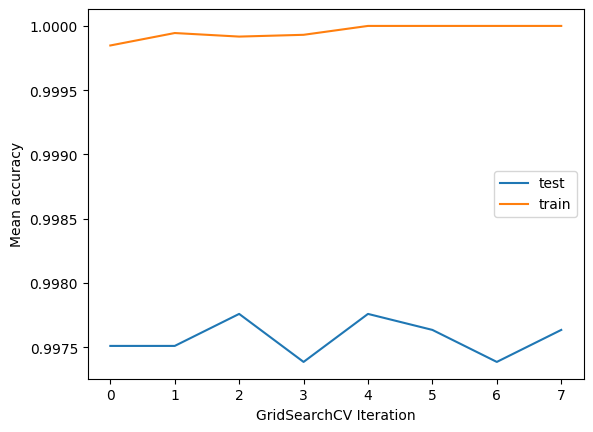

In [15]:
test_scores = cvres['mean_test_score']
train_scores = cvres['mean_train_score']

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.xlabel('GridSearchCV Iteration')
plt.ylabel('Mean accuracy')
plt.legend(loc='best')
plt.grid(visible=False)
plt.show()

### 4.2 Matrice di confusione

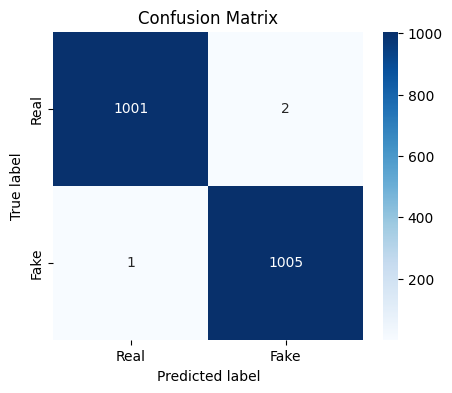

<Figure size 640x480 with 0 Axes>

In [16]:
cm = confusion_matrix(y_test, y_pred)
class_names = ['Real', 'Fake']

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Salva il grafico come file PDF
plt.savefig('confusion_matrix_NameOfClassifier.pdf', format='pdf')

### 4.3 Roc Curve

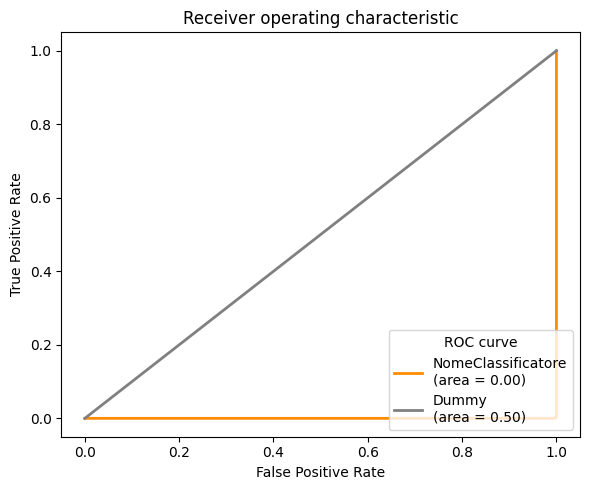

In [17]:
most_frequent = dummy.DummyClassifier(strategy='most_frequent')

y_score = rfc_final.predict_proba(X_test)
most_frequent_score = most_frequent.fit(X_train, y_train).predict_proba(X_test)

# Calcolo della curva ROC per la classe 'fake'
fpr, tpr, _ = roc_curve(y_test, y_score[:, 0])
roc_auc = auc(fpr, tpr)

fpr_dummy, tpr_dummy, _ = roc_curve(y_test, most_frequent_score[:, 1])
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)
lw = 2

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=lw,
label='NomeClassificatore\n(area = %0.2f)' % roc_auc)
plt.plot(fpr_dummy, tpr_dummy, color='.5', lw=lw,
label='Dummy\n(area = %0.2f)' % roc_auc_dummy)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", title='ROC curve')
plt.tight_layout()
plt.show()